In [ ]:
import numpy as np
import pandas as pd
# %matplotlib notebook
import pickle
import os
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import Counter
from sklearn import metrics
from datetime import datetime
from utils import *
from joblib import Parallel, delayed
from copy import deepcopy
import math

def return_important_vars(episode_presence,n_lag=15,n_cluster = 4,obs = 30):
    # data_file = './data/episode_encoded_lagged_data_with_episode/episode_encoded_'+'lagged_'+str(n_lag)+'_obs_{}'.format(obs)+'_windows_with_episode_cluster_check_{}'.format(n_cluster)
    data_file = '../data/episode_encoded_lagged_data_with_episode/episode_encoded_'+'lagged_'+str(n_lag)+'_obs_{}'.format(obs)+'_windows_cluster_{}'.format(n_cluster)
    # filename = './data/output_final_all/result_'+str(episode_label)+'_episode_lag_{}_obs_{}_triplet_loss_cluster_{}.p'.format(n_lag,obs,n_cluster)        
    if episode_presence==0:
        episode_label = 'only'
        # filename = './data/output_final_all/result_only_episode_lag_{}_obs_{}_triplet_loss_cluster___pos_to_neg_none_v111{}{}.p'.format(n_lag,obs,n_cluster,.2)    
        filename = './data/output_final_all/result_only_episode_lag_{}_obs_{}_triplet_loss_cluster_{}_revised_loss_alpha_{}_softmax_{}_loss_{}_rare_{}_positive_{}_percentile_{}.p'.format(n_lag,obs,n_cluster,.2,50,10,1,.2,80)
        filename = '../data/final_output/model_name_ddhi_episode_False_cross_entropy_weight_10_loss_weight_50_is_triplet_False_ratio_0.4_n_cluster_4_lag_15_obs_30.p'
        filename = '../data/final_output/model_name_ddhi_episode_False_cross_entropy_weight_10_loss_weight_50_is_triplet_False_ratio_0.2_n_cluster_4_lag_15_obs_30_iters_50.p'
        # filename = './data/output_final_all/distance_lag_15_obs_30_triplet_loss_cluster_4_triplet_loss_alpha_0.2_softmax_1_loss_1_rare_1_positive_0.2_percentile_80.p'
        # filename = './data/output_final_all/no_episode_distance_lag_15_obs_30_triplet_loss_cluster_4_revised_loss_alpha_0.35_softmax_10_loss_50_rare_1_positive_0.2_percentile_80.p'
    elif episode_presence==1:
        episode_label = 'with'
        filename = './data/output_final_all/result_'+str(episode_label)+'_episode_lag_{}_obs_{}_triplet_loss_cluster_{}.p'.format(n_lag,obs,n_cluster)        
    elif episode_presence==2:
        episode_label = 'no'
        # filename = './data/output_final_all/result_'+str(episode_label)+'_episode_lag_{}_obs_{}_triplet_loss_cluster___pos_to_neg_none_v111{}{}.p'.format(n_lag,obs,n_cluster,.2)  
        filename = '../data/output_final_all/result_no_episode_lag_{}_obs_{}_triplet_loss_cluster_{}_revised_loss_alpha_{}_softmax_{}_loss_{}_rare_{}_positive_{}_percentile_{}.p'.format(n_lag,obs,n_cluster,.2,10,50,1,.2,80)    
        # filename = './data/output_final_all/no_episode_distance_lag_15_obs_30_triplet_loss_cluster_4_triplet_loss_alpha_0.3_softmax_1_loss_1_rare_1_positive_0.2_percentile_80.p'  
        # filename = '../data/final_output/model_name_dres_episode_False_cross_entropy_weight_10_loss_weight_50_is_triplet_False_ratio_0.2_n_cluster_4_lag_15_obs_30.p' 
        # filename = '../data/final_output/model_name_dres_episode_False_cross_entropy_weight_10_loss_weight_50_is_triplet_False_ratio_0.35_n_cluster_4_lag_15_obs_30_iters_50.p'
    
        
    data_eval = pickle.load(open(filename,'rb'))
    file1 = '../data/mRisk/mRisk_Lapse_postquit.csv'
    puff_data = pd.read_csv(file1)
    data_feature_label = pickle.load(open(data_file,'rb'))
    data_cluster = pickle.load(open(data_file,'rb'))
    temp = data_cluster.groupby(['user','cluster_label']).count().index.values
    users = np.array([a[0] for a in temp])
    labels = np.array([a[1] for a in temp])
    cluster_dict = {}
    for i,a in enumerate(users):
        cluster_dict[a] = labels[i]
    y_time,y_pred,y_test,y_pid,bias_dict,val_results = data_eval[0],np.array(data_eval[1]),data_eval[2],data_eval[3],data_eval[4],data_eval[5]
    y_time,y_pred,y_test,y_pid,pars = np.array(y_time),np.array(y_pred).reshape(len(y_test),-1),np.array(y_test),np.array(y_pid),np.unique(y_pid)
    lapse_captured_dict = {}
    total_lapsers = 0
    result_phenotypes_final = {}
    return y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict

for percentile in np.arange(80,92,200):
    print(percentile,'-*-'*10)
    n_lag = 15
    n_cluster = 4
    obs = 30
    label = 'DRES'
    all_dfs = []
    from sklearn.preprocessing import MinMaxScaler, RobustScaler
    for episode_presence in [0,2]:
        y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict = return_important_vars(episode_presence=episode_presence,n_lag=n_lag)
        if episode_presence==0:
            label = 'DDHI'
        elif episode_presence==1:
            label = 'DDHI (Only Episode)'
        elif episode_presence==2:
            label = 'DRES'
        y_pred_final = []
        print(y_pred.shape)
        for user in np.unique(y_pid):
            a = np.where(y_pid==user)[0]
            y_pred_pid = y_pred[a]
            biases = np.array(bias_dict[user])
            # np.percentile(y_pred_pid[:,ii],80)
            # if label=='DRES':
            # y_pred_pid = RobustScaler().fit_transform(y_pred_pid)
            # print(np.std(y_pred_pid,axis=0))
            for ii in range(y_pred_pid.shape[1]):
                y_pred_pid[:,ii] = np.array(y_pred_pid[:,ii]>=np.percentile(y_pred_pid[:,ii],percentile),dtype=int)
            # for ii in range(y_pred_pid.shape[1]):
            #     y_pred_pid[:,ii] = np.average(y_pred_pid[:,ii],weights=y_pred_pid[:,ii])
            
            y_pred_pid = np.mean(y_pred_pid,axis=1) 
            
            y_pred_final.extend(list(y_pred_pid))
        df = pd.DataFrame({'Original':y_test,'Predicted':y_pred_final,'User':y_pid,'Time':y_time})
        df['Model'] = [label]*df.shape[0]
        all_dfs.append(df)

    df_final = pd.concat(all_dfs)
    # df_final.Predicted.plot(kind='hist')
    def get_lapse_times(puff_data,par):
        return np.array([np.datetime64(datetime.fromtimestamp(lapse_time/1000)) for lapse_time in puff_data[puff_data['Participant']==int(par)]['Lapse'].values])


    def get_positive_only_prediction(df):
        df = df.sort_values('Time').reset_index(drop=True)
        lapse_times = get_lapse_times(puff_data,df['User'].values[0])
        if len(lapse_times)==0:
            return pd.DataFrame([],columns=df.columns)
        df['Lapse'] = [-1]*df.shape[0]
        indexes = []
        for i,row in df.iterrows():
            for j,lapse in enumerate(lapse_times[:1]):
                if row['Time']<=lapse and abs((row['Time']-lapse).total_seconds()/60)<=100:
                    indexes.append(i)
                    df['Lapse'].at[i] = j
        return df.loc[indexes]

    df_all_final = df_final.groupby(['User','Model'],as_index=False).apply(get_positive_only_prediction)

    final_df = []
    final_df_burden = []
    for bias in np.arange(0.02,1,.01):
        def get_results(df):
            if df.shape[0]<5:
                return pd.DataFrame([],columns=['y_test','y_pred','user','Model'])
            model_name = df['Model'].values[0]
            user = df['User'].values[0]
            if np.max(df['Predicted'])>=bias:
                y_pred = 1
            else:
                y_pred = 0
            return pd.DataFrame({'y_test':[1],'y_pred':[y_pred],'user':[user],'Model':[model_name]})

        results = df_all_final.groupby(['User','Model','Lapse'],as_index=False).apply(get_results).reset_index(drop=True)
        from sklearn.metrics import accuracy_score
        results['y_test'] = np.int64(results['y_test'])
        results['y_pred'] = np.int64(results['y_pred']) 
        results_scores = results.groupby('Model',as_index=False).apply(lambda a:pd.Series({'Accuracy':accuracy_score(a['y_test'],a['y_pred'])}))
        results_scores['Bias'] = bias
        final_df.append(results_scores)
        temp_data = []
        for model in ['DDHI','DRES']:
            if model not in df_final.Model.unique():
                continue
            ratio_ = 100*df_final[df_final.Model.isin([model])&(df_final.Predicted>bias)].shape[0]/df_final[df_final.Model.isin([model])].shape[0]
            temp_data.append([model,bias,ratio_])
        final_df_burden.append(pd.DataFrame(temp_data,columns=['Model','Bias','Accuracy']))
    df_burden = pd.concat(final_df_burden)
    final_df_result = pd.concat(final_df)
    
    bias_col = {}
    burden_col = {}
    for model in ['DDHI','DRES']:
        if model not in final_df_result.Model.unique():
            continue
        bias_col[model] = final_df_result[(final_df_result['Accuracy']>=0.8)&(final_df_result.Model==model)]['Bias'].max()
        burden_col[model] = df_burden[(df_burden.Bias>=bias_col[model])&(df_burden.Model==model)]['Accuracy'].max()
    
    
    
    import seaborn as sns
    colors = ['navy',"salmon"]
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    colors = {'DDHI':colors[0],'DRES':colors[1]}

    plt.rcParams.update({'font.size':18})
    plt.figure(figsize=(7,5))
    sns.lineplot(x='Bias',y='Accuracy',hue='Model',data=final_df_result[final_df_result.Model!='DHI'].reset_index(drop=True))
    # plt.vlines([.620],0,.8,color='tab:blue',linestyle='--',label=r'$B_L, DDHI$')
    # plt.vlines([.5],0,.8,color='orange',linestyle='--',label=r'$B_L, DRES$')

    # plt.vlines(bias_col,0,.8,color='tab:blue',linestyle='--',label=r'$B_L, DDHI$')
    plt.hlines([.8],0,max(list(bias_col.values()))+.01,color='k',linestyle='-.',label='Accuracy = 0.8')
    for model in bias_col.keys():
        plt.vlines([bias_col[model]],0,.8,linestyle='--',color=colors[model])
        if model=='DDHI':
            x_temp = bias_col[model]
        else:
            x_temp = bias_col[model]-.06
        plt.text(x_temp,.25,r'$T_L = $'+'{:.2f}'.format(bias_col[model]),rotation=90,color=colors[model])

    # plt.text(.45,.45,r'$B_L = 0.5$',color='orange',rotation=90)
    # plt.text(.57,.32,r'$B_L = 0.62$',color='tab:blue',rotation=90)
    # plt.arrow(x=.499, y=.4, dx=.08, dy=0, width=.01,label='Improvement in ') 
    # plt.vlines([.5],0,1,color='g',linestyle='--',label='Decision Threshold')
    # plt.hlines([.8],0,.620,color='k',linestyle='-.',label='Accuracy = 0.8')
    plt.ylim([0,1.1])
    plt.xlim([0,1.1])
    plt.legend(frameon=False)
    plt.xlabel('High Risk Decision Threshold, '+r'$T_L$')
    plt.ylabel('Lapse Event \nPrediction Accuracy')
    plt.tight_layout()
    plt.title(str(percentile))
    # plt.savefig('./data/images/detection_accuracy.png')
    plt.show()


    plt.figure(figsize=(7,5))
    sns.lineplot(x='Bias',y='Accuracy',hue='Model',data=df_burden.reset_index(drop=True))


    for kkk,model in enumerate(list(bias_col.keys())):
        plt.vlines([bias_col[model]],0,burden_col[model],linestyle='--',color=colors[model])
        plt.hlines([burden_col[model]],[0],[bias_col[model]],linestyle='--',color=colors[model])
        if model=='DDHI':
            x_temp = bias_col[model]
        else:
            x_temp = bias_col[model]-.06
        # plt.text(x_temp,2,'{:.2f}'.format(bias_col[model]),rotation=90,color=colors[model])
        if model=='DRES':
            plt.text(.02,burden_col[model]+6,'{:.2f}%'.format(burden_col[model]),color=colors[model])
        else:
            plt.text(.02,burden_col[model]-8,'{:.2f}%'.format(burden_col[model]),color=colors[model])
    # plt.vlines([0.62],0,28.88,color='tab:blue',linestyle='--')
    # plt.vlines([0.5],0,44.014,color='orange',linestyle='--')
    # plt.text(.45,2,r'$B_L = 0.5$',color='orange',rotation=90)
    # plt.text(.57,2,r'$B_L = 0.62$',color='tab:blue',rotation=90)

    # plt.hlines([28.88,44.014],[0,0],[.62,.5],color='k',linestyle='--')
    # plt.text(.1,45,'Perc. = {}%'.format(44.01),color='orange')
    # plt.text(.1,30,'Perc. = {}%'.format(28.88),color='tab:blue')
    # plt.arrow(x=.2, y=28.88, dx=0, dy=12, width=.01,head_width=0.02,head_length=0.02,color='g',length_includes_head=True)
    # plt.text(.21,30.5,'Improvement \nfor DDHI (~12%)',color='g') 
    plt.ylim([0,110])
    plt.xlim([0,1.1])
    plt.legend(frameon=False)
    plt.xlabel('High Risk Decision Threshold, '+r'$T_L$')
    plt.ylabel('Percentage of Windows \nlabelled High Risk')
    plt.tight_layout()
    # plt.savefig('./data/images/burden.png')
    plt.show()

    plt.figure(figsize=(5,5))
    sns.kdeplot(x='Predicted',hue='Model',data=df_final.reset_index(drop=True),multiple='layer',common_norm=False,fill=False)
    plt.xlabel('mRisk Lapse Likelihood')
    # plt.ylabel('Frequency')
    plt.tight_layout()
    # plt.savefig('./data/images/histogram_of_risk_likelihood.png')
    plt.show()

In [ ]:
ema_data = pd.read_csv('../data/EMA_smoking_times1.csv')
ema_data = ema_data[['Participant','Starttime','Howmany Cigs?']]
ema_data['Time'] = ema_data['Starttime'].apply(lambda a:datetime.fromtimestamp(a/1000))
ema_data['day'] = ema_data['Time'].apply(lambda a:str(a)[:10])
puff_data['Time'] = puff_data['Lapse'].apply(lambda a:datetime.fromtimestamp(a/1000))
puff_data['day'] = puff_data['Time'].apply(lambda a:str(a)[:10])
df_final1 = df_final[df_final.Model=='DDHI']
df_final1['day'] = df_final1['Time'].apply(lambda a:str(a)[:10])

In [ ]:
# df_final1['Verdict'] = 0
# df_final1.loc[df_final1['Predicted']>=.31,'Verdict'] = 1
# confusion_matrix(df_final1['Original'],df_final1['Verdict'])
from dateutil import parser
filename = '../data/all_ema_phase1_3001_3171.csv'
ema_data = pd.read_csv(filename)
ema_data = ema_data[(ema_data['Status']=='COMPLETED') & (ema_data['Day']>1)]
ema_data['Starttime'] = ema_data['Starttime'].apply(lambda a:datetime.fromtimestamp(a/1000))
smoking_columns = ['How long ago smoke first cig','Recent cig how long ago?','How long ago?']
time_columns = ['Time.43','Time.42','Time.41']
for c in time_columns:
       ema_data[c] = ema_data[c].apply(lambda a:datetime.fromtimestamp(a/1000))

dict_transform = {'None':12, '0 - 2 hrs':0, '2 hrs - 4 hrs':2, '8 hrs - 10 hrs':8,
       '10 hrs - 12 hrs':10, '6 hrs - 8 hrs':6, '4 hrs - 6 hrs':8,
       'More than 12 hrs':12}
for c in smoking_columns:
       ema_data[c] = ema_data[c].apply(lambda a:dict_transform[a])
ema_data = ema_data[['Starttime','Participant','Howmany Cigs?','Smoked Cig?']+time_columns+smoking_columns]
all_days = []
colors_line= ['r','g','b']
count = 0
lapse_times_dict = {}
for user in df_final1.User.unique():
    ema_user = ema_data[ema_data.Participant==int(user)]
    df_user = df_final1[df_final1.User==user]
    lapse_times_dict[user] = {}
    for day in df_user.day.unique():
        lapse_times_dict[user][day] = []
        df_user_day = df_user[df_user.day==day].sort_values('Time').reset_index(drop=True)
        # df_user_day['Time'] = df_user_day['Time'].apply(lambda a:a+np.timedelta64(15,'m'))
        df_user_day['ema_lapse'] = 0
        if df_user_day.shape[0]<120:
            continue
        start_time = np.datetime64(parser.parse(day))
        end_time = np.datetime64(parser.parse(day))+np.timedelta64(24,'h')
        ema_user_day = ema_user[(ema_user.Starttime>=start_time)&(ema_user.Starttime<=end_time)]
        x1 = [[],[],[]]
        for j,aa in enumerate(list(zip(smoking_columns,time_columns))):
            column,columnt = aa
            for i,ema in ema_user_day.iterrows():
                n1 = ema[column]
                if n1==12:
                    continue
                # if not (ema[smoking_columns[0]] == 12 and ema[smoking_columns[1]] == 12):
                #         print(n1,ema[smoking_columns[0]],ema[smoking_columns[1]])
                #         continue
                n2 = n1+2
                n1t = ema[columnt]-np.timedelta64(n1,'h')
                n2t = ema[columnt]-np.timedelta64(n2,'h')
                
                # df_user_day[(df_user_day.Time>=n2t)&(df_user_day.Time<=n1t)]['ema_lapse'] = 1
                index = df_user_day[(df_user_day.Time>=n2t)&(df_user_day.Time<=n1t)].index.values
                if len(index)< 30:
                    # df_user_day.loc[index]['ema_lapse'] = 1
                    continue
                df_user_day.loc[(df_user_day.Time>n2t)&(df_user_day.Time<n1t),'ema_lapse']=1
                lapse_times_dict[user][day].append(n2t)
                # df_user_day.loc[(df_user_day.Time>n2t)&(df_user_day.Time<n1t),'Predicted']= np.percentile(df_user_day[(df_user_day.Time>n2t)&(df_user_day.Time<n1t)]['Predicted'],80)
                if len(index) < 30:
                #     df_user_day.loc[index]['ema_lapse'] = 1
                    continue
                x1[j].append(np.array([n1t,n2t]))
                # x2.append(n2t)
                # y.append(int(ema['Howmany Cigs?']))
        zeros = 0
        all_days.append(df_user_day)
        for a in x1:
            if len(a)==0:
                zeros+=1
        if zeros==3:
            continue       
    #     plt.figure(figsize=(20,4))
    #     plt.plot(df_user_day['Time'],df_user_day['Predicted'],'--*')
    #     plt.hlines([bias_col['DDHI']],[df_user_day['Time'].min()],[df_user_day['Time'].max()],linestyle=':')
    #     for k,a in enumerate(x1):
    #         if len(a)==0:
    #             continue
    #         a = np.array(a)
    #         plt.hlines([k/3]*len(a),a[:,1],a[:,0],colors_line[k],linestyle='--',linewidth=5,label=smoking_columns[k])
    #     plt.legend()
    #     plt.ylim([0,1])
    #     # plt.vlines(x2,0,1,'r')
    #     # plt.vlines(x1,0,1,'g')
    #     plt.show()
    #     count+=1
    # if count>20:
    #     break

In [ ]:
# df = list(df_final.groupby(['User']))[1][1].sort_values('Time').reset_index(drop=True)

In [ ]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d


def get_int_times_count(y_time_pid,y_pred_pid,timescap,bias):
    ipd = 0
    int_times = []
    prev_time = np.min(y_time_pid)
    for p,ys in enumerate(y_pred_pid):
        timedelta = y_time_pid[p] - prev_time
        mins = timedelta.astype('timedelta64[m]').astype(np.int32)
        if mins>=timescap and ys>bias:
            ipd+=1
            int_times.append(y_time_pid[p])
            prev_time = y_time_pid[p]
    return np.array(int_times), ipd

def check_lapse(a,lapse_time):
    if a<=lapse_time and (lapse_time-a)/np.timedelta64(1,'m') <= first_gap:
        return True  
    if a>=lapse_time and (a-lapse_time)/np.timedelta64(1,'m') <= second_gap:
        return True
    return False
def ascertain_lapse(lapse_time, int_times):
    lapse_captured = 0
    int_times_lapse = sorted(np.array([a for a in int_times if check_lapse(a,lapse_time)]))
    if len(int_times_lapse)>0:
        lapse_captured+=1
    return lapse_captured

def parse_per_day(df,bias=.31):
    df = df.sort_values('Time').reset_index(drop=True)
    user = df['User'].values[0]
    day = df['day'].values[0]
    total_ipd = 0
    part_days = 0
    lapse_captured = 0
    original = 0
    y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in df['Time'].values])
    y_pred_pid = df['Predicted'].values
    lapse_times = lapse_times_dict[user][day]
    if len(lapse_times)==0:
        return pd.DataFrame([],columns=['int_count','day_count','lapse_captured','original_lapse'])
    # final_lapse_time = [[]]
    # for i,lapse_time in enumerate(lapse_times):
    #     if i>0 and np.abs((lapse_time-lapse_times[i-1])/np.timedelta64(1,'m'))>10:
    #         final_lapse_time.append([])
    #         final_lapse_time[-1].append(lapse_time)
    #     else:
    #         final_lapse_time[-1].append(lapse_time)
    # lapse_times = np.array([np.min(a) for a in final_lapse_time])
    original += len(lapse_times)
    part_days+=1
    int_times, ipd =  get_int_times_count(y_time_pid,y_pred_pid,timescap=60,bias=bias)
    total_ipd+=ipd

    if len(int_times)>0:
        for lapse_time in lapse_times:
            lapse_captured += ascertain_lapse(lapse_time, int_times)
    
    return pd.DataFrame([[total_ipd,
                             part_days,
                             lapse_captured,
                             original]],columns=['int_count','day_count','lapse_captured','original_lapse'])

def parse_user_data(df,bias=.31):
    result = pd.concat([parse_per_day(df,bias=bias) for i,df in df.groupby('day')])
    if result.shape[0]==0:
        return pd.DataFrame([],columns=['User','freq','acc'])
    int_freq = result['int_count'].sum()/result['day_count'].sum()
    lapse_captured_acc = result['lapse_captured'].sum()/result['original_lapse'].sum()
    user = df['User'].values[0]
    return pd.DataFrame([[user,int_freq,lapse_captured_acc]],columns=['User','freq','acc'])


def parse_for_bias(df_final,bias=.31):
    result = pd.concat([parse_user_data(df,bias=bias) for i,df in df_final.groupby('User')])
    if result.shape[0]>0:
        result = result.sort_values('freq').reset_index(drop=True)
        x = result['freq'].values
        y = result['acc'].values
        return pd.DataFrame({'bias':[bias],'int_freq':[np.percentile(x,55)],'ihr':[np.percentile(y,55)]})
        # return pd.DataFrame([[bias,result['freq'].mean(),result['acc'].mean()+.05]],columns=['bias','int_freq','ihr'])
        # return pd.DataFrame([[bias,result['freq'].quantile(.6),result['acc'].quantile(.6)]],columns=['bias','int_freq','ihr'])
    else:
        return pd.DataFrame([],columns=['bias','int_freq','ihr'])

def smooth_result(y,window=7,polynomial=3):
    y = savgol_filter(y,window, polynomial)
    return y
  
from joblib import Parallel, delayed
time_gap_delta = 20
first_gap = 60


results_final = []
for second_gap in np.arange(0,130,10):
    df_final = pd.concat(all_days)
    x_new = np.arange(2,7.5,.5)
    result = pd.concat(Parallel(n_jobs=10,verbose=0)(delayed(parse_for_bias)(df_final,bias=a) for a in np.arange(.14,.9,.005))).sort_values('int_freq').reset_index(drop=True)
    x = result['int_freq'].values
    y = result['ihr'].values
    f = interp1d(x,y,fill_value='extrapolate',bounds_error=False)
    y_new = f(x_new)
    y_new = smooth_result(y_new)
    y_new[y_new>=1] = 1
    from pprint import pprint
    results_final.append(pd.DataFrame(np.array(list(zip([second_gap]*len(x_new),x_new,y_new))),columns=['Coverage','Int_freq','Ihr']))
    
from copy import deepcopy
temp = deepcopy(pd.concat(results_final))

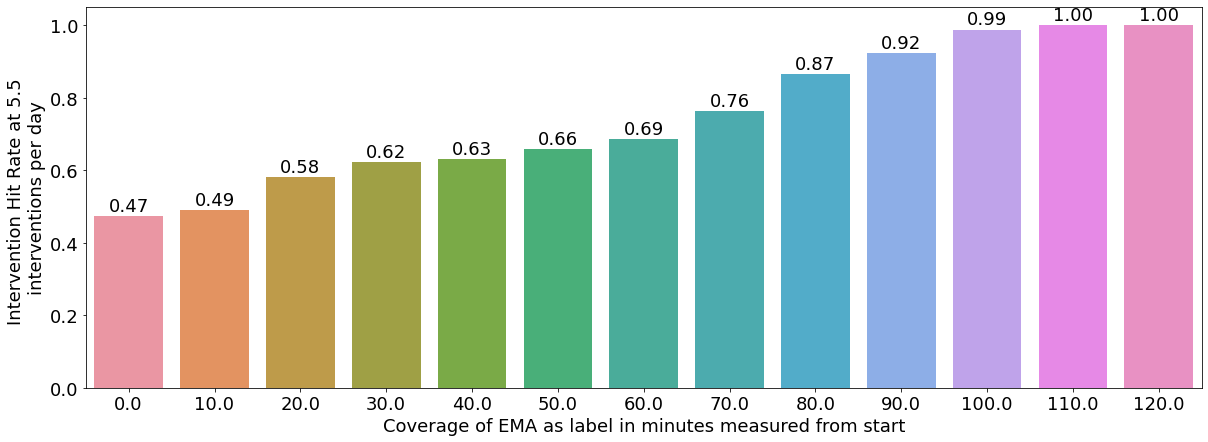

In [159]:

results_final = temp[temp.Int_freq==5.5][['Coverage','Ihr']].values
# results_final = np.array(results_final)
# np.array(list(zip(x_new,y_new)))[7,:]
df = pd.DataFrame(results_final)
plt.figure(figsize=(20,7))
ax = sns.barplot(x=0,y=1,data=df)
# ax.bar_label(ax.containers[0])
# ax.containers[0]
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel('Coverage of EMA as label in minutes measured from start')
plt.ylabel('Intervention Hit Rate at 5.5 \ninterventions per day')
plt.show()

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


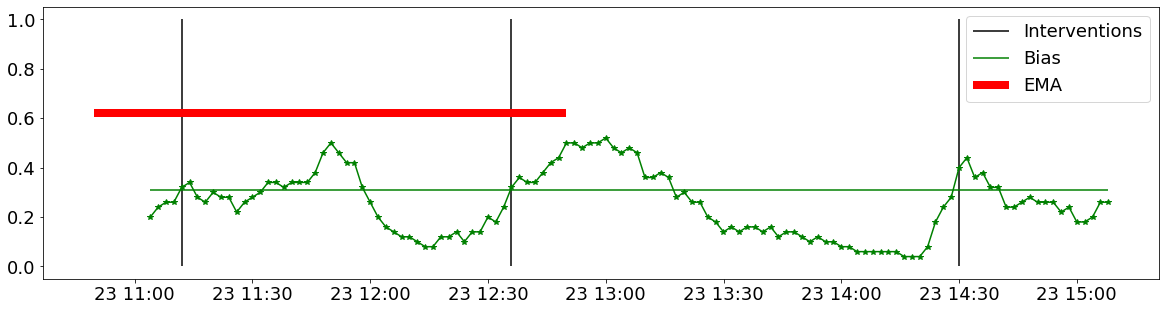

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


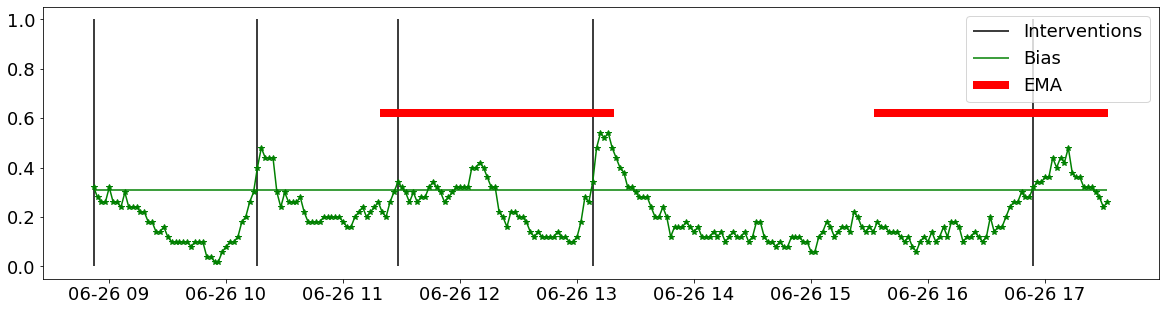

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


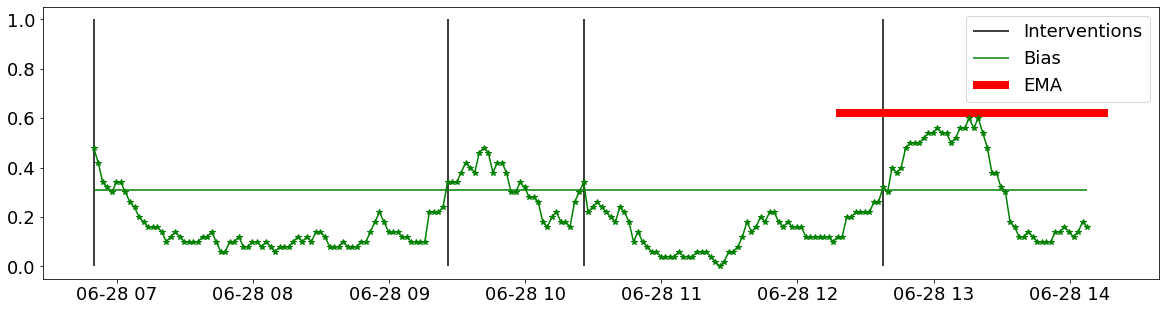

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


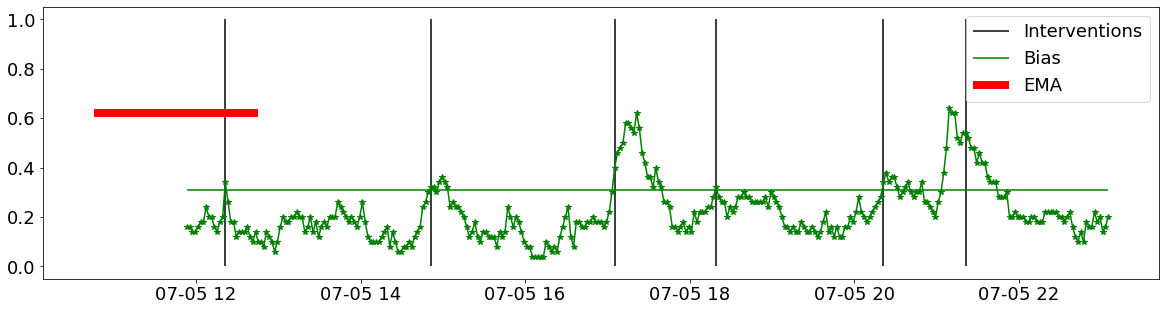

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


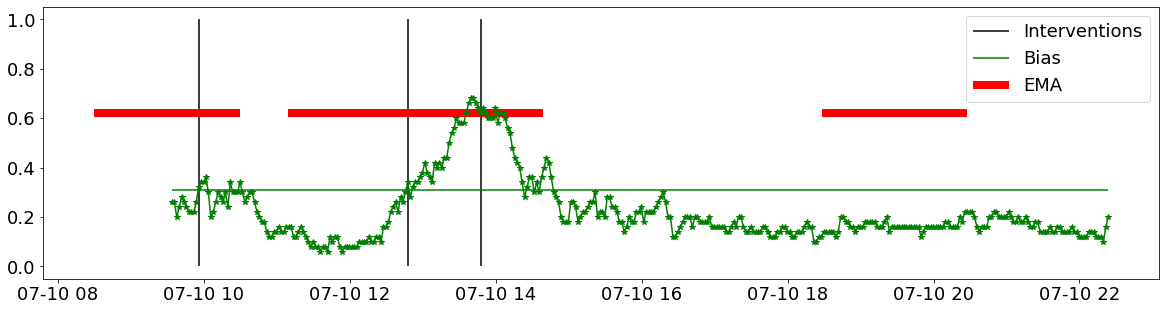

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


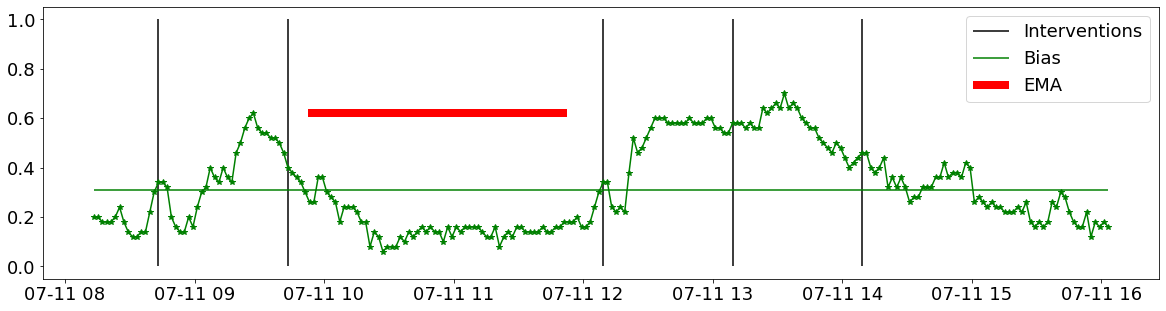

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


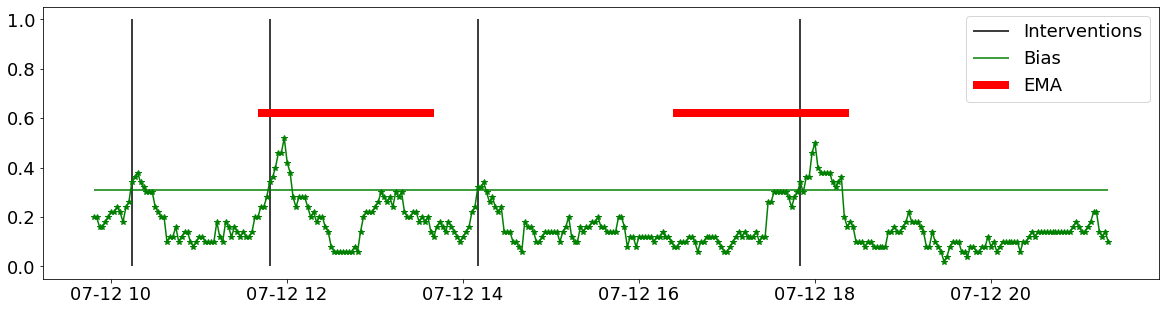

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


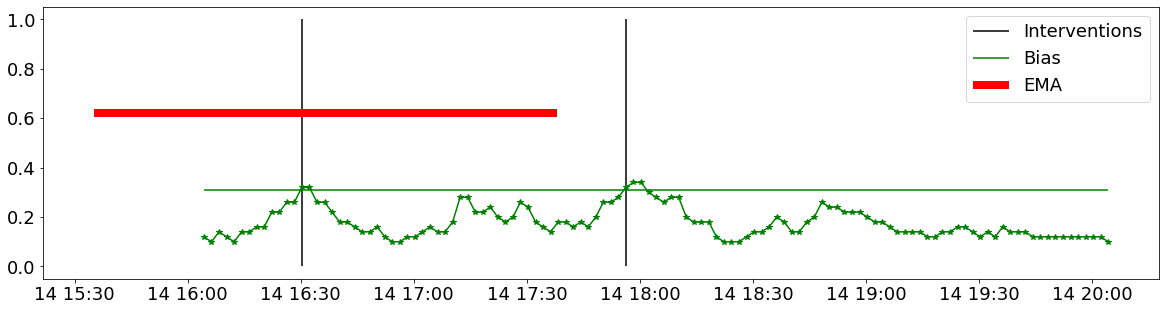

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


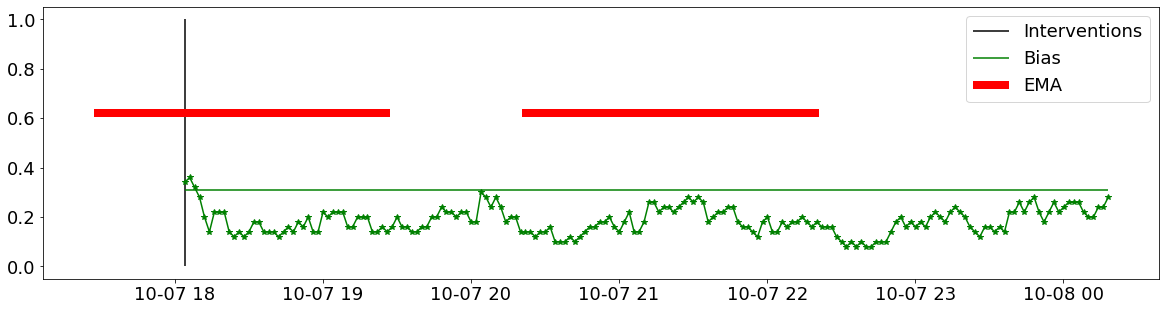

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


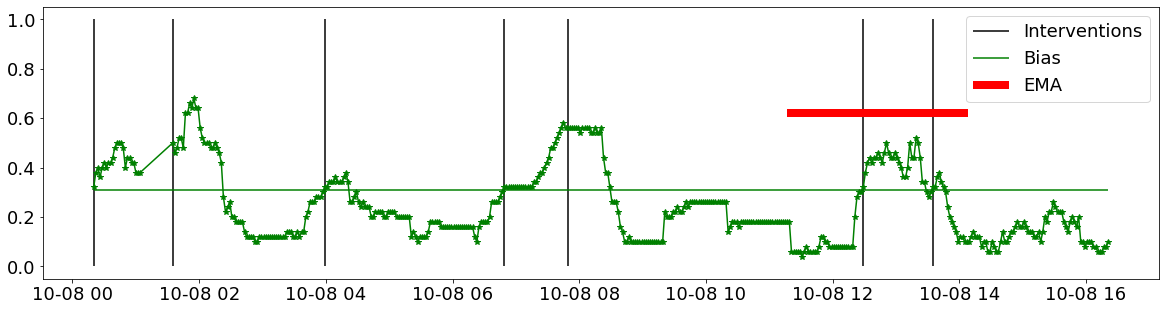

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


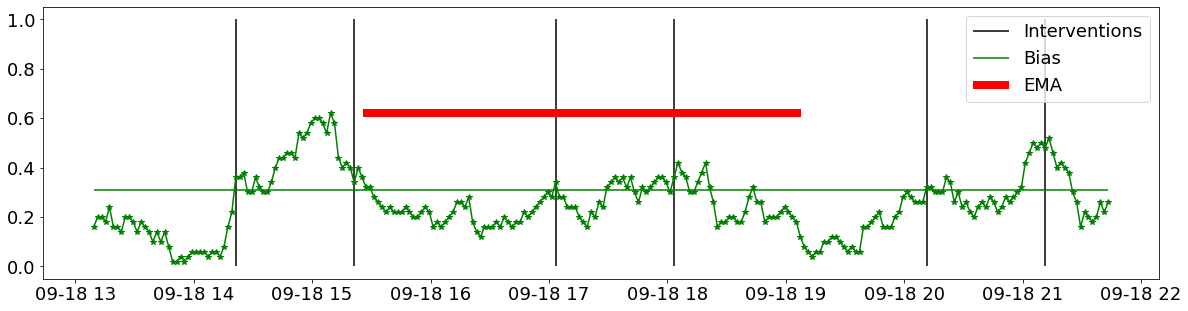

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


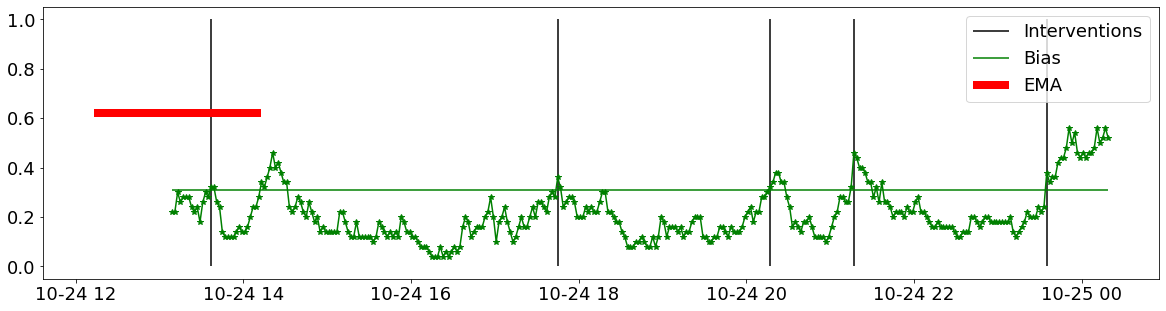

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


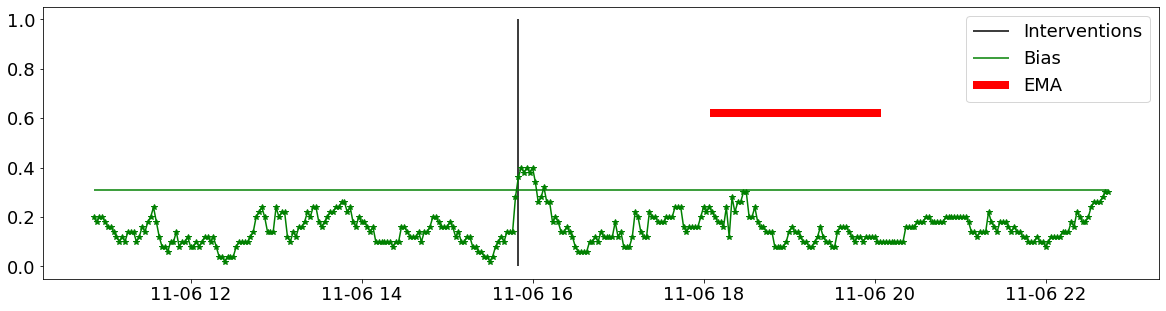

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


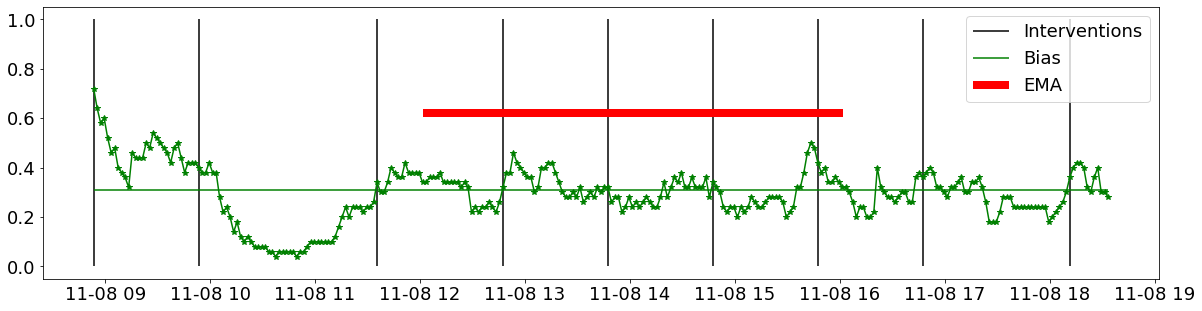

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


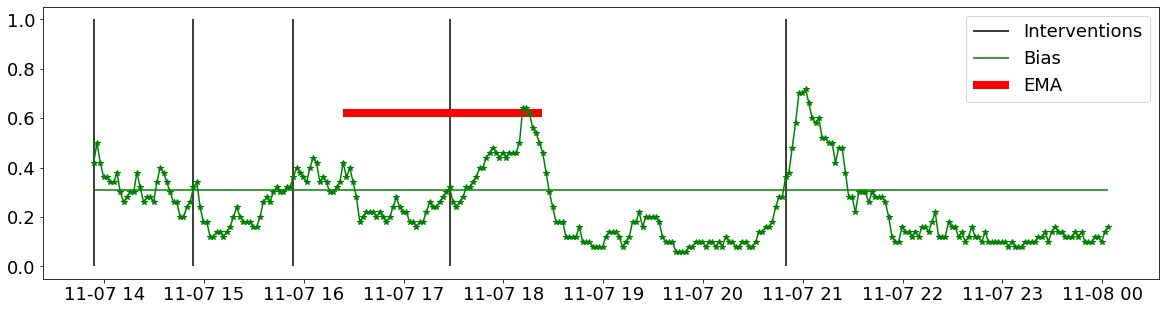

<ipython-input-166-19c2aa6f2fbb>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if prev_time==0 and ys>bias:


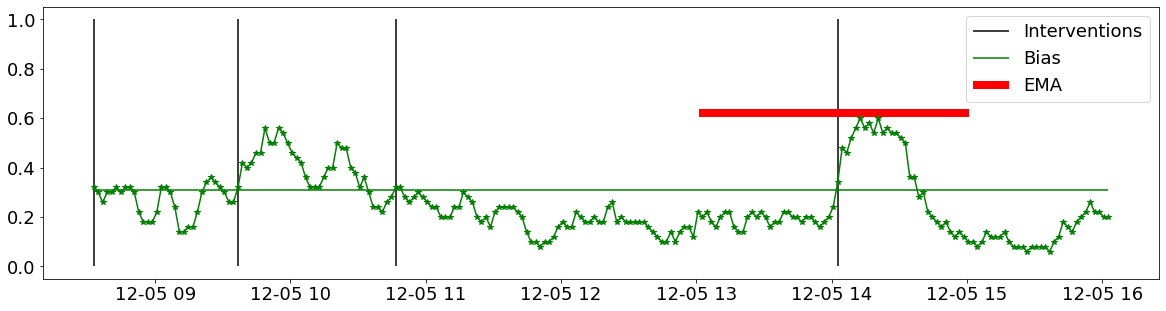

In [166]:
def get_int_times_count(y_time_pid,y_pred_pid,timescap,bias):
    ipd = 0
    int_times = []
    prev_time = 0
    for p,ys in enumerate(y_pred_pid):
        if prev_time==0 and ys>bias:
            ipd+=1
            int_times.append(y_time_pid[p])
            prev_time = y_time_pid[p]
        else:
            timedelta = y_time_pid[p] - prev_time
            mins = timedelta.astype('timedelta64[m]').astype(np.int32)
            if mins>=timescap and ys>bias:
                ipd+=1
                int_times.append(y_time_pid[p])
                prev_time = y_time_pid[p]
    return np.array(int_times), ipd

def parse_per_day(df,bias=.31):
    df = df.sort_values('Time').reset_index(drop=True)
    user = df['User'].values[0]
    day = df['day'].values[0]
    total_ipd = 0
    part_days = 0
    lapse_captured = 0
    original = 0
    y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in df['Time'].values])
    y_pred_pid = df['Predicted'].values
    lapse_times = lapse_times_dict[user][day]
    if len(lapse_times)==0:
        return pd.DataFrame([],columns=['int_count','day_count','lapse_captured','original_lapse'])
    original += len(lapse_times)
    part_days+=1
    int_times, ipd =  get_int_times_count(y_time_pid,y_pred_pid,timescap=60,bias=bias)
    
    
    plt.figure(figsize=(20,5))
    plt.plot(y_time_pid,y_pred_pid,'-g*')
    plt.vlines(int_times,0,1,color='k',label='Interventions')
    plt.hlines(bias,y_time_pid[0],y_time_pid[-1],color='g',label='Bias')
    lapse_times_1 = np.array([a+np.timedelta64(120, 'm') for a in lapse_times])
    plt.hlines([bias*2]*len(lapse_times),lapse_times,lapse_times_1,color='red',linewidth=8,label='EMA')
    plt.legend()
    plt.show()
    
    total_ipd+=ipd

    if len(int_times)>0:
        for lapse_time in lapse_times:
            lapse_captured += ascertain_lapse(lapse_time, int_times)
    
    return pd.DataFrame([[total_ipd,
                             part_days,
                             lapse_captured,
                             original]],columns=['int_count','day_count','lapse_captured','original_lapse'])
df_final = pd.concat(all_days)
users = df_final.User.unique()[:20]
df_final = df_final[df_final.User.isin(users)]
second_gap = 60
result = pd.concat([parse_for_bias(df_final,bias=a) for a in [.31]]).sort_values('int_freq').reset_index(drop=True)
 

In [ ]:
x = result['int_freq'].values
y = result['ihr'].values
f = interp1d(x,y,fill_value='extrapolate',bounds_error=False)
y_new = f(x_new)
y_new = smooth_result(y_new)
y_new[y_new>=1] = 1
from pprint import pprint
pprint(np.array(list(zip(x_new,y_new)))[7,1])
# plt.figure(figsize=(10,5))
# plt.plot(x_new,y_new,'-r*')
# plt.show()

In [ ]:
df_final['Verdict'] = 0
df_final.loc[df_final.Predicted>=bias_col['DDHI'],'Verdict'] = 1
dict_ = Counter(df_final[(df_final.Original==0)]['ema_lapse'])
print('Lapse ratio within unlabeled data from ema', dict_[1]/(dict_[1]+dict_[0]))
from sklearn.metrics import confusion_matrix,roc_auc_score
roc_value = roc_auc_score(df_final[(df_final.Original==0)]['ema_lapse'],df_final[(df_final.Original==0)]['Predicted'])
print('AUC of mrisk score to predict ema based lapses within unlabeled data',roc_value)
matrix = confusion_matrix(df_final[(df_final.Original==0)]['ema_lapse'],df_final[(df_final.Original==0)]['Verdict'])
print('TPR within unlabeled data',matrix[1,1]/(matrix[1,1]+matrix[1,0]))

sns.heatmap(matrix,annot=True,fmt='2d')
plt.xlabel('Predicted by mRisk')
plt.ylabel('Coded from EMA')
plt.show()

In [ ]:
all_days = []
colors_line= ['r','g','b']
count = 0
for user in df_final1.User.unique():
    ema_user = ema_data[ema_data.Participant==int(user)]
    df_user = df_final1[df_final1.User==user]

    for day in df_user.day.unique():
        df_user_day = df_user[df_user.day==day].sort_values('Time').reset_index(drop=True)
        # df_user_day['Time'] = df_user_day['Time'].apply(lambda a:a+np.timedelta64(15,'m'))
        df_user_day['ema_lapse'] = 0
        if df_user_day.shape[0]<120:
            continue
        start_time = np.datetime64(parser.parse(day))
        end_time = np.datetime64(parser.parse(day))+np.timedelta64(24,'h')
        ema_user_day = ema_user[(ema_user.Starttime>=start_time)&(ema_user.Starttime<=end_time)]
        x1 = [[],[],[]]
        for j,aa in enumerate(list(zip(smoking_columns,time_columns))[:2]):
            column,columnt = aa
            for i,ema in ema_user_day.iterrows():
                n1 = ema[column]
                if n1==12:
                    continue
                n2 = n1+2
                n1t = ema[columnt]-np.timedelta64(n1,'h')
                n2t = ema[columnt]-np.timedelta64(n2,'h')
                
                # df_user_day[(df_user_day.Time>=n2t)&(df_user_day.Time<=n1t)]['ema_lapse'] = 1
                index = df_user_day[(df_user_day.Time>n2t)&(df_user_day.Time<n1t)].index.values
                if len(index)==0:
                #     df_user_day.loc[index]['ema_lapse'] = 1
                    continue
                df_user_day.loc[(df_user_day.Time>n2t)&(df_user_day.Time<n1t),'ema_lapse']=1
                df_user_day.loc[(df_user_day.Time>n2t)&(df_user_day.Time<n1t),'Predicted']= np.percentile(df_user_day[(df_user_day.Time>n2t)&(df_user_day.Time<n1t)]['Predicted'],80)
                # if len(index)==0:
                #     df_user_day.loc[index]['ema_lapse'] = 1
                    # continue/
                x1[j].append(np.array([n1t,n2t]))
                # x2.append(n2t)
                # y.append(int(ema['Howmany Cigs?']))
        # df_user_day.loc[(df_user_day.Time>n2t)&(df_user_day.Time<n1t),'Predicted']= np.percentile(df_user_day[(df_user_day.Time>n2t)&(df_user_day.Time<n1t)]['Predicted'],80)
        zeros = 0
        all_days.append(df_user_day)
        for a in x1:
            if len(a)==0:
                zeros+=1
        if zeros==3:
            continue       
    #     plt.figure(figsize=(20,4))
    #     plt.plot(df_user_day['Time'],df_user_day['Predicted'],'--*')
    #     for k,a in enumerate(x1):
    #         if len(a)==0:
    #             continue
    #         a = np.array(a)
    #         plt.hlines([k/3]*len(a),a[:,1],a[:,0],colors_line[k],linestyle='--',linewidth=5,label=smoking_columns[k])
    #     plt.legend()
    #     # plt.vlines(x2,0,1,'r')
    #     # plt.vlines(x1,0,1,'g')
    #     plt.show()
    #     count+=1
    # if count>20:
    #     break

In [ ]:
df_final = pd.concat(all_days)
df_final['Verdict'] = 0
df_final.loc[df_final.Predicted>=bias_col['DDHI'],'Verdict'] = 1
dict_ = Counter(df_final[(df_final.Original==0)]['Verdict'])
print('Lapse ratio within unlabeled data from ema', dict_[1]/(dict_[1]+dict_[0]))
from sklearn.metrics import confusion_matrix,roc_auc_score
roc_value = roc_auc_score(df_final[(df_final.Original==0)]['ema_lapse'],df_final[(df_final.Original==0)]['Predicted'])
print('AUC of mrisk score to predict ema based lapses within unlabeled data',roc_value)
matrix = confusion_matrix(df_final[(df_final.Original==0)]['ema_lapse'],df_final[(df_final.Original==0)]['Verdict'])
print('TPR within unlabeled data',matrix[1,1]/(matrix[1,1]+matrix[1,0]))

sns.heatmap(matrix,annot=True,fmt='2d')
plt.xlabel('Predicted by mRisk')
plt.ylabel('Coded from EMA')
plt.show()

In [ ]:
df_final = pd.concat(all_days)
df_final['Verdict'] = 0
df_final.loc[df_final.Predicted>=.41,'Verdict'] = 1
dict_ = Counter(df_final[(df_final.Original==0)]['ema_lapse'])
print('Lapse ratio within unlabeled data from ema', dict_[1]/(dict_[1]+dict_[0]))
from sklearn.metrics import confusion_matrix,roc_auc_score
roc_value = roc_auc_score(df_final[(df_final.Original==0)]['ema_lapse'],df_final[(df_final.Original==0)]['Predicted'])
print('AUC of mrisk score to predict ema based lapses within unlabeled data',roc_value)
matrix = confusion_matrix(df_final[(df_final.Original==0)]['ema_lapse'],df_final[(df_final.Original==0)]['Verdict'])
print('TPR within unlabeled data',matrix[1,1]/(matrix[1,1]+matrix[1,0]))

sns.heatmap(matrix,annot=True,fmt='2d')
plt.xlabel('Predicted by mRisk')
plt.ylabel('Coded from EMA')
plt.show()

In [ ]:
df_user_day['ema_lapse'].unique()

In [ ]:
from datetime import timedelta
bias = .31
ig = 60
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def return_intervention_times(x,y):
    x_int = []
    y_int = []
    for i,row in enumerate(x):
        if y[i]<bias:
            continue
        if len(x_int)==0:
            x_int.append(row)
        elif (row-x_int[-1])/np.timedelta64(1, 'm') >=ig:
            x_int.append(row)
    return x_int,y_int
#3046
#3163
wanted = '3163'
for par in df_final1.User.unique():
    participant_all_day = df_final1[df_final1.User==par]
    if par!=wanted:
        par = int(wanted)
        continue
    for k,day in enumerate(participant_all_day.day.unique()):
        lapse_times = puff_data[(puff_data.Participant==int(par))&(puff_data.day==day)].sort_values('Time').reset_index(drop=True)
        if lapse_times.shape[0]==0:
            lapse_day = False
        else:
            x_lapses = np.array([a for a in lapse_times['Time'].values if pd.to_datetime(a).hour>=5])
            if len(x_lapses)>0:
                lapse_day = True
            else:
                lapse_day = False
        ema_day_data = ema_data[(ema_data.Participant==int(par))&(ema_data.day==day)].sort_values('Time').reset_index(drop=True)
        ema_day = False
        if ema_day_data.shape[0]>0:
            x_emas = ema_day_data['Time'].values
            x_emas = np.array([a for a in x_emas if pd.to_datetime(a).hour>=5])
            if len(x_emas)>0:
                ema_day = True
        # if not lapse_day:
        #     continue
        # if not ema_day:
        #     continue
        print(par,day)
        participant_day = participant_all_day[participant_all_day .day==day].sort_values('Time').reset_index(drop=True)
        # if participant_day.shape[0]<200:
        #     continue
        
        
        
        x = participant_day['Time'].values
        x_hour = np.array([pd.to_datetime(a).hour for a in x])        
        y = participant_day['Predicted'].values.reshape(-1)
        x_int,y_int = return_intervention_times(x,y)
        x = x[x_hour>=5]
        y = y[x_hour>=5]        
        x_int_hour = np.array([pd.to_datetime(a).hour for a in x_int])
        x_int = np.array(x_int)[x_int_hour>=5]
        # y_int = np.array(y_int)[x_int_hour>=5]        
        
        plt.rcParams.update({'font.size':17})
        plt.figure(figsize=(13,5))
        plt.plot(x,y,'--*',c='g')
        plt.vlines(x_int,0,.8,color='brown',linestyles='--',label='Intervention Times')
        
        min_x,max_x = np.min(x),np.max(x)
        plt.hlines(bias,min_x,max_x,linestyles='--',color='k',label='Threshold, '+ r'$T_L$')
        if ema_day:
            if wanted=='3031':
                x_emas = x_emas[1:]
            plt.vlines(x_emas,0,.8,color='k',linewidth=3,label='EMA Report Times')
        
        if lapse_day:
            plt.vlines(x_lapses-np.timedelta64(0,'m'),0,.8,color='red',linewidth=3,label='Lapse Time')
            # max_time = np.max([])
        # plt.hlines(0.5,x_lapses,x_emas,linewidth=7,color='tab:blue')
        # plt.text(x_lapses[0]+np.timedelta64(31,'m'),.45,'{:.2f}\nmins'.format((x_emas[0]-x_lapses[0])/np.timedelta64(1,'m')),color='tab:blue',fontsize=15,fontweight=10)
        plt.ylim([0,1])
        # plt.legend(ncol=3,frameon=False,loc='upper left')
        if wanted == '3031':
            plt.legend(loc = (-.06,1.05),ncol=4,frameon=False)
        else:
            plt.legend(loc = (.06,1.05),ncol=4,frameon=False)
        plt.xticks(x[np.arange(0,len(x),20)],np.array([str(a)[11:16] for a in x])[np.arange(0,len(x),20)],rotation=60)
        plt.ylabel('mRisk \nLapse Likelihood')
        plt.xlabel('Time')
        # plt.tight_layout()
        # plt.savefig('./data/images/lapse_risk_{}.png'.format(par))
        plt.show()
        
        # plt.figure(figsize=(15,2))
        # sns.heatmap(np.array(y).reshape(1,-1),vmax= 1,vmin=0,cmap='vlag')
        
        # plt.show()
        
        # fig,ax = plt.subplots(2,1,figsize)
        
        

In [ ]:
df1 = pd.DataFrame({'x':x,'y':y}).set_index('x').resample('60S').mean().fillna(method='ffill')

In [ ]:
# x = df1.index.values
# y = df1['y'].values
# puff_data[puff_data.Participant==3046]
import tensorflow_probability as tfp

In [ ]:
x_emas[]

In [ ]:
# inc = ['3002', '3004', '3005', '3006', '3007', '3009', '3013', '3014', '3015', '3022', '3024', '3025', '3029', '3031', '3033',
#  '3036', '3038', '3041', '3045', '3048', '3050', '3053', '3076', '3077', '3079', '3086', '3088', '3091', '3095', '3099',
#  '3101', '3102', '3122', '3125', '3126', '3128', '3133', '3135', '3137', '3138', '3139', '3143', '3145', '3148', '3152',
#  '3153', '3158', '3160', '3164', '3165', '3166', '3168']
plt.rcParams.update({'font.size':17})
bias = .32
from datetime import timedelta
ig = 60
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
inc = df_final1.User.unique()
for par in inc[:3]:
    temp1 = df_final1[df_final1.User==par]
    for day in temp1.day.unique():
        lapse_time = puff_data[puff_data.Participant==int(par)]['Lapse'].values[0]
        lapse_time = np.datetime64(datetime.fromtimestamp(lapse_time/1000))
        temp = temp1[temp1.day==day].sort_values('Time').reset_index(drop=True)
        x = temp['Time'].values
        y = smooth(temp['Predicted'].values,2).reshape(-1)
        x_int = []
        y_int = []
        for i,row in enumerate(x):
            if y[i]<bias:
                continue
            if len(x_int)==0:
                x_int.append(row)
            elif (row-x_int[-1])/np.timedelta64(1, 'm') >=ig:
                x_int.append(row)
        plt.figure(figsize=(15,5))
        plt.plot(x,y,'*--',c='tab:blue')
        plt.vlines(x_int,0,1,color='k',Label='Intervention Times')
        # plt.vlines([lapse_time-np.timedelta64(0,'m')],0,1,color='red')
        # plt.text(lapse_time-np.timedelta64(0,'m'),.5,'Lapse Time',rotation=90,color='red')
        print((lapse_time-x_int[-1])/np.timedelta64(1,'m'))
        plt.xticks(x[np.arange(0,len(x),10)],np.array([str(a)[11:16] for a in x])[np.arange(0,len(x),10)],rotation=90)
        # plt.title(par+'-'+day)
        plt.xlabel('Time')
        plt.ylabel('Lapse Likelihood, DDHI')
        plt.legend()
        plt.show()

In [ ]:
lapse_time

In [ ]:
import seaborn as sns
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(7,5))
sns.histplot(y_pred_final,bins=10)
plt.xlabel('mRisk Lapse Likelihood (DDHI)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./data/images/histogram_of_risk_likelihood.png')
plt.show()

In [ ]:
df.loc[df.shape[0]-1]

In [ ]:
df[-1:]

In [ ]:
import shap

In [ ]:
?shap.DeepExplainer